In [3]:
from typing import Union, List

import numpy as np
from scipy.sparse import csr_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.exceptions import NotFittedError
from sklearn.metrics import f1_score
from tqdm import tqdm


class PeriodEstimatorWrapper(BaseEstimator):

    def __init__(self, clf: BaseEstimator, **params):
        self.clf = clf(**params)
        if params.get('verbose'):
            self.verbose = params['verbose']

    def fit(self, X_train: Union[csr_matrix, np.ndarray], y_train: np.array):
        """
        Fits the estimator.

        :param X_train: normal feature matrix e.g. shape (n_samples, n_features)
        :param y_train: label vector shape (n_samples,)
        :return: fitted instance of itself
        """

        self.clf.fit(X_train, y_train)
        self.fitted_ = True

        return self

    def predict(self, X_test: List[Union[csr_matrix, np.ndarray]]):
        """
        Predicts classes for n periods
        :param X_test: list of feature matrices (n_samples, n_features) to predict (one for each period)
        :return: list of predicted label vectors
        """

        if not self.fitted_:
            raise NotFittedError

        result = []
        if self.verbose:
            iterator = tqdm(X_test, desc='Predicting classes for periods')
        else:
            iterator = X_test

        for X in iterator:
            result.append(self.clf.predict(X))

        return result

    def predict_proba(self, X_test: List[Union[csr_matrix, np.ndarray]]):
        """
        Predicts probabilities for n periods
        :param X_test: list of feature matrices (n_samples, n_features) to predict (one for each period)
        :return: list of predicted label vectors
        """
        if not hasattr(self.clf, 'predict_proba'):
            raise Exception(f"Method predict_proba is not implemented in {self.clf.__class__.__name__}")

        if not self.fitted_:
            raise NotFittedError

        result = []
        if self.verbose:
            iterator = tqdm(X_test, desc='Predicting classes for periods')
        else:
            iterator = X_test

        for X in iterator:
            result.append(self.clf.predict_proba(X))

        return result

    def decision_function(self, X_test: List[Union[csr_matrix, np.ndarray]]):
        """
        Predicts decision scores for n periods
        :param X_test: list of feature matrices (n_samples, n_features) to predict (one for each period)
        :return: list of predicted label vectors
        """
        if not hasattr(self.clf, 'decision_function'):
            raise Exception(f"Method decision_function is not implemented in {self.clf.__class__.__name__}")

        if not self.fitted_:
            raise NotFittedError

        result = []
        if self.verbose:
            iterator = tqdm(X_test, desc='Predicting classes for periods')
        else:
            iterator = X_test

        for X in iterator:
            result.append(self.clf.predict_proba(X))

        return result

    def score(self,
              X_test: List[Union[csr_matrix, np.ndarray]],
              y_true: List[np.array],
              scoring_func: callable = lambda y_true, y_pred: f1_score(y_true, y_pred, average='macro'),
              pooling_func: callable = np.mean):

        if not self.fitted_:
            raise NotFittedError

        scores = []
        for X, y in zip(X_test, y_true):
            y_pred = self.clf.predict(X)
            score = scoring_func(y, y_pred)
            scores.append(score)

        return pooling_func(scores)

    
class PeriodTransformerWrapper(TransformerMixin):
    
    def __init__(self, transformer, **transformer_params):
        self.transformer = transformer(**transformer_params)
    
    def fit(self, X):
        self.transformer.fit(X)
    
    def transform(self, X):
        if np.array(X).ndim == 3:
            X_t = []
            for x in X:
                X_t.append(self.transformer.transform(x))
                
        else:
            X_t = self.transformer.transform(X)
        return X_t

In [4]:
pt = PeriodTransformerWrapper(TfidfVectorizer)
pt.fit(list(periods.values())[0].text)
train = pt.transform(list(periods.values())[0].text)
test = pt.transform([p.text for p in periods.values()])

NameError: name 'TfidfVectorizer' is not defined

In [5]:
import pandas as pd

/Users/lennartkeller/anaconda3/envs/nlp/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/lennartkeller/anaconda3/envs/nlp/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [53]:
df = pd.read_csv('full_dataset.csv').dropna()
df = df[df.period != 'WMD']

In [54]:
# remove news genre
df = df[df.genre != 'NEWS']

In [25]:
ignore = ('WMD')
periods = {}
for period in sorted(df.period.unique()):
    if period not in ignore:
        periods[period] = df.loc[df['period'] == period]
        
periods.keys()

dict_keys(['P1', 'P2', 'P3', 'P4', 'P5', 'P6'])

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from stop_words import get_stop_words

tfidf = TfidfVectorizer(stop_words=get_stop_words('de'))

p_train = tfidf.fit_transform(list(periods.values())[0].text)
y_train = list(periods.values())[0].genre.to_numpy()
p_test = tfidf.transform([p.text for p in periods.values()])
y_test = [p.genre.to_numpy() for p in periods.values()]

AttributeError: 'Series' object has no attribute 'lower'

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
clf = PeriodEstimatorWrapper(MultinomialNB)

In [27]:
clf.fit(p_train, y_train)

NameError: name 'clf' is not defined

In [98]:
scores = clf.score(p_test, y_test, pooling_func=lambda x: x)
scores

[1.0,
 0.6057247958606193,
 0.48032143679510186,
 0.6846182155350599,
 0.6934784900402424,
 0.5588023088023087]

In [99]:
import matplotlib.pyplot as plt

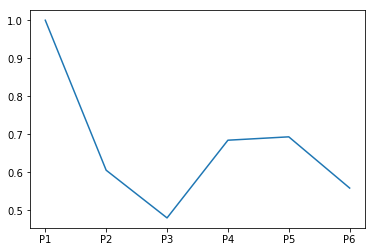

In [100]:
plt.plot(list(periods.keys()), scores)
plt.show()

In [79]:
def visualize_periods() -> plt.Figure:
    """
    Returns a plot of each pipe passed, trained on one period and applied to the others.
    TODOs:
        * We should handle each genre on its own.
        * 
    """
    return 

/Users/lennartkeller/anaconda3/envs/nlp/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


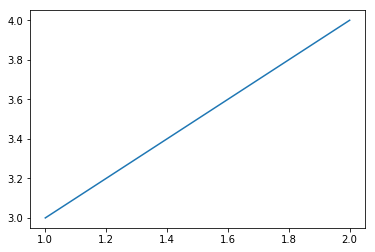

In [85]:
fig = plt.figure()
plt.plot([1,2], [3,4])
fig.show()

In [55]:
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [56]:
df_train, df_test = train_test_split(df, random_state=42)

In [61]:
from sklearn.neural_network import MLPClassifier
pipe = make_pipeline(TfidfVectorizer(), MLPClassifier(verbose=3))

In [62]:
pipe.fit(df_train.text, df_train.period)

Iteration 1, loss = 1.77417883
Iteration 2, loss = 1.68270876
Iteration 3, loss = 1.57630798
Iteration 4, loss = 1.46206898
Iteration 5, loss = 1.34167139
Iteration 6, loss = 1.21881141
Iteration 7, loss = 1.09833535
Iteration 8, loss = 0.98037417
Iteration 9, loss = 0.86888861
Iteration 10, loss = 0.76443242
Iteration 11, loss = 0.66843720
Iteration 12, loss = 0.58218140
Iteration 13, loss = 0.50501292
Iteration 14, loss = 0.43789661
Iteration 15, loss = 0.37923120
Iteration 16, loss = 0.32764838
Iteration 17, loss = 0.28364520
Iteration 18, loss = 0.24648695
Iteration 19, loss = 0.21429600
Iteration 20, loss = 0.18762472
Iteration 21, loss = 0.16492697
Iteration 22, loss = 0.14563687
Iteration 23, loss = 0.12917675
Iteration 24, loss = 0.11537282
Iteration 25, loss = 0.10366387
Iteration 26, loss = 0.09349494
Iteration 27, loss = 0.08489693
Iteration 28, loss = 0.07738635
Iteration 29, loss = 0.07096366
Iteration 30, loss = 0.06533752
Iteration 31, loss = 0.06040862
Iteration 32, los

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token...
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=(100,),
                               learning_rate='constant',
                               learning_rat

In [63]:
y_pred = pipe.predict(df_test.text)
y_pred[:2]

array(['P6', 'P4'], dtype='<U2')

In [64]:
print(classification_report(df_test.period.to_numpy(), y_pred))

              precision    recall  f1-score   support

          P1       0.63      0.68      0.65        25
          P2       0.47      0.38      0.42        24
          P3       0.66      0.83      0.73        23
          P4       0.77      0.47      0.59        36
          P5       0.37      0.62      0.46        21
          P6       0.88      0.81      0.85        37

    accuracy                           0.63       166
   macro avg       0.63      0.63      0.62       166
weighted avg       0.67      0.63      0.63       166



In [36]:
df_test.period.to_numpy().shape, y_pred.shape

((166,), (8,))